In [158]:
%load_ext autoreload
%autoreload 2

from saveload import *
from c_mnist import *
from models import *
from functions import *
from torchvision.datasets import MNIST, FashionMNIST
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


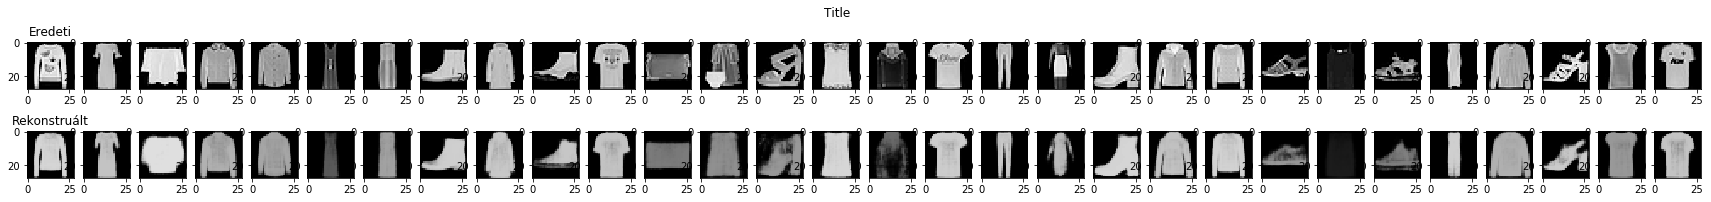

In [165]:
model = load_model(SMVAE_NORMAL, '//mnt/smvae/normal/Normal_SMVAE_60000_0_1_var0.003_seed0.pth')
dataset = create_testset(FashionMNIST, 0.8, 1, return_validation=False)
compare(model, dataset, 30)

In [344]:
#torch.load(ROOT+'evaluation/logs_fashion_seed0.txt')

In [507]:
ROOT = '//mnt/smvae/'
mnist0 = torch.load(ROOT+'evaluation/eval_mnist_seed0.txt')
mnist1 = torch.load(ROOT+'evaluation/eval_mnist_seed1.txt')
fashion0 = torch.load(ROOT+'evaluation/eval_fashion_seed0.txt')
fashion1 = torch.load(ROOT+'evaluation/eval_fashion_seed1.txt')
results = {**mnist0, **mnist1, **fashion0, **fashion1}

In [689]:
df = pd.DataFrame.from_dict(results, orient='index')
df = df.reindex(sorted(df.index), axis=0)
df = df.rename(columns={0:'ELBO', 1:'REC', 2:'neg_KL'})
df = df.round(2)

df['type'] = [ind.split('_')[0]+'_'+ind.split('_')[1] for ind in df.index]
df['data'] = [ind.split('_')[2] for ind in df.index]
df['size'] = [int(ind.split('_')[3]) for ind in df.index]
df['contrast'] = [str(ind.split('_')[4:6]).replace("'","") for ind in df.index]
df['var'] = [float(ind.split('_')[6][3:]) for ind in df.index]
df['seed'] = [int(ind.split('_')[7][-1:]) for ind in df.index]

df = df[df['type']!='Beta_SMVAE']

df_full = df[df['contrast']=="[0, 1]"]
df_hi = df[df['contrast']=="[0.8, 1]"]
df_lo = df[df['contrast']=="[0, 0.2]"]

In [690]:
random_seed=1
models_standard_mnist = load_folder(VAE, 'standard/mnist', random_seed)
models_standard_fashion = load_folder(VAE, 'standard/fashion', random_seed)
models_normal_mnist = load_folder(SMVAE_NORMAL, 'normal/mnist', random_seed)
models_normal_fashion = load_folder(SMVAE_NORMAL, 'normal/fashion', random_seed)

models_mnist = models_standard_mnist + models_normal_mnist 
models_fashion = models_standard_fashion + models_normal_fashion

In [676]:
set_seed(random_seed)
testset_mnist = create_testset(FashionMNIST, return_validation=False)
testset_fashion = create_testset(MNIST, return_validation=False)

#means, variances, contrasts = get_averages(model, testset)

In [677]:
c_means = torch.Tensor([torch.sigmoid(tensor[-1]) for tensor in means])
contrasts = torch.Tensor(contrasts)

In [684]:
'''for i in range(20):
    print(torch.sigmoid(m1[i][-1]), c1[i])'''

def plot_contrast(contrasts, c_means, title, regression=True):
    plt.scatter(contrasts, c_means, s=1)

    # Perform linear regression using PyTorch
    if regression:
        x = contrasts.view(-1, 1)  # Reshape to a column vector
        y = c_means.view(-1, 1)  # Reshape to a column vector
        X = torch.cat([x, torch.ones_like(x)], dim=1)  # Augmented input matrix [x, 1]
        w, _ = torch.lstsq(y, X)
        regression_line = x * w[0] + w[1]
        plt.plot(contrasts, regression_line, label='Regression Line', color='red')

    plt.ylim(0, 1.1)
    plt.xlabel('Contrast ground truth')
    plt.ylabel('Posterior mean of c')
    plt.title(title)

    # Display the plot
    plt.show()

In [691]:
for model in models_normal_mnist:
    means, variances, contrasts = get_averages(model, testset_mnist)
    c_means = torch.Tensor([torch.sigmoid(tensor[-1]) for tensor in means])
    contrasts = torch.Tensor(contrasts)
    c_variances = torch.Tensor([tensor[-1] for tensor in variances])
    #plot_contrast(contrasts, c_means, model.name, regression=False)
    
for model in models_normal_fashion:
    means, variances, contrasts = get_averages(model, testset_fashion)
    c_means = torch.Tensor([torch.sigmoid(tensor[-1]) for tensor in means])
    contrasts = torch.Tensor(contrasts)
    #plot_contrast(contrasts, c_means, model.name, regression=False)

In [ ]:
def plot_elbos(df, df2, c='green', c2='orange'):
    fig, ax = plt.subplots()
    title = df['data'][0] + '_' + df['contrast'][0] + '_seed' + str(df['seed'][0])
    labels = [600, 2000, 6000, 20000, 60000]
    values = list(df['ELBO'])
    values2 = list(df2['ELBO'])

    ax.plot(range(1, len(labels)+1), values, marker='o', linestyle=':', color=c, label=df['type'][0])
    ax.plot(range(1, len(labels)+1), values2, marker='o', linestyle=':', color=c2, label=df2['type'][0])
    #ax.plot(range(1, 8), values3, marker='o', linestyle=':')

    plt.grid(axis='y')

    # Set the x-axis labels to the values in x_labels
    ax.set_xticks(range(1, len(labels)+1))
    ax.set_xticklabels(labels, rotation=45)  # You can adjust the rotation angle as needed

    '''for i, value in enumerate(values):
        ax.text(i + 1, value, str(value), fontsize=10, ha='center', va='bottom')
    for i, value in enumerate(values2):
        ax.text(i + 1, value, str(value), fontsize=10, ha='center', va='bottom')'''
    
    # Optional: Add labels and a title
    ax.set_xlabel('Dataset size')
    ax.set_ylabel('ELBO')
    ax.set_title(title)
    ax.legend()

    # Show the plot
    plt.show()
    
def df_subset(df_contrast, myseed, mytype, mydata):
    mydf = df_contrast[(df_contrast.seed==myseed)&(df_contrast.type==mytype)&(df_contrast.data==mydata)]
    mydf = mydf.sort_values('size', ascending=True)
    return mydf

In [692]:
types = ['Normal_SMVAE', 'Standard_VAE']
datasets = ['mnist', 'fashion']
df_contrasts = [df_full, df_hi, df_lo]

for dataset in datasets:
    for df_contrast in df_contrasts:
        for seed in range(2):
            df_to_plot = df_subset(df_contrast, seed, types[0], dataset)
            df_to_plot2 = df_subset(df_contrast, seed, types[1], dataset)
            #plot_elbos(df_to_plot, df_to_plot2)